In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary

from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
from PIL import Image
import random, os
import numpy as np
import seaborn as sns



In [2]:
import os
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/input/pcos-dataset/PCOS"

# Collect all image paths and labels
data = []
labels = []

for label, subdir in enumerate(["infected", "noninfected"]):
    class_dir = os.path.join(data_dir, subdir)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append(img_path)
        labels.append(label)

# Split into 80% train, 20% test
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

# Save as lists for DataLoader usage
train_dataset = list(zip(train_data, train_labels))
test_dataset = list(zip(test_data, test_labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust if RGB images
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CustomPCOSDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        path, label = self.data_list[index]
        try:
            image = Image.open(path).convert("RGB")  # Ensure RGB mode
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return None  # Skip corrupted files

# Create dataset instances
train_dataset = CustomPCOSDataset(train_dataset, transform=train_transforms)
test_dataset = CustomPCOSDataset(test_dataset, transform=test_transforms)


In [4]:
class CustomPCOSDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        path, label = self.data_list[index]
        try:
            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Skipping corrupted file: {path} ({e})")
            return self.__getitem__((index + 1) % len(self.data_list))  # Try next image


In [5]:
from torch.utils.data import random_split

batch_size = 128
val_size = 400
train_size = len(train_dataset) - val_size  # Use dynamically created train_dataset

# Split train dataset into train and validation sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_dataset)}")  # Print test size for reference


Length of Train Data : 9027
Length of Validation Data : 400
Length of Test Data : 2357


In [6]:
# Function to filter out None values (corrupted images)
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if batch else None

# DataLoaders for train, validation, and test sets
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size=batch_size*2, collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)

print("DataLoaders initialized successfully!")


DataLoaders initialized successfully!


torch.Size([128, 3, 256, 256]) torch.Size([128])


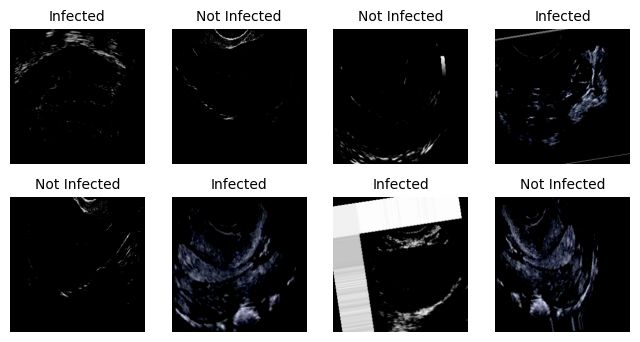

In [7]:
# Get one batch from dataset
images, labels = next(iter(train_dl))
print(images.shape, labels.shape)  # Expecting (batch_size, 3, 256, 256)

plt.figure(figsize=(8,4))

for i in range(8):
    plt.subplot(2,4,i+1)
    
    # Convert from (C, H, W) to (H, W, C) for correct image display
    plt.imshow(images[i].permute(1, 2, 0))  
    
    plt.title('Infected' if labels[i] == 0 else 'Not Infected', fontsize=10)
    plt.axis("off")

plt.show()


In [8]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}] -------------------------")  # Show epoch progress
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


# CNN 1 Block

In [28]:
import torch
import torch.nn as nn

class CNN1Block(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1),  # Conv layer
            nn.ReLU(),
            nn.MaxPool2d(3, 3)  # MaxPooling layer
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(12 * 85 * 85, 2)  # Adjust based on output size after pooling

    def forward(self, xb):

        xb = self.block1(xb)  # Pass through block1 (Conv + ReLU + MaxPool)
     
        xb = self.flatten(xb)  # Flatten the output for the fully connected layer
      

        xb = self.fc(xb)       # Fully connected layer for classification
       
        return xb

# Dummy input to check the size
dummy_input = torch.randn(128, 3, 256, 256)  # Batch size 128, 3 channels, 256x256 image
model = CNN1Block()

# Check the size step by step
with torch.no_grad():
    output = model(dummy_input)


In [18]:
model = CNN1Block().to(device)  #  using the appropriate device (GPU/CPU)

# Print the model summary
summary(model, input_size=(3, 256, 256))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 256, 256]             336
              ReLU-2         [-1, 12, 256, 256]               0
         MaxPool2d-3           [-1, 12, 85, 85]               0
           Flatten-4                [-1, 86700]               0
            Linear-5                    [-1, 2]         173,402
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 13.32
Params size (MB): 0.66
Estimated Total Size (MB): 14.74
----------------------------------------------------------------


In [19]:
print("Training with 1 CNN block")
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Training with 1 CNN block
Epoch [0], train_loss: 0.6030, val_loss: 0.3715, val_acc: 0.8322
Epoch [1], train_loss: 0.3192, val_loss: 0.2406, val_acc: 0.9060
Epoch [2], train_loss: 0.2464, val_loss: 0.1622, val_acc: 0.9490
Epoch [3], train_loss: 0.2204, val_loss: 0.1299, val_acc: 0.9596
Epoch [4], train_loss: 0.1822, val_loss: 0.1358, val_acc: 0.9460
Epoch [5], train_loss: 0.1744, val_loss: 0.1387, val_acc: 0.9557
Epoch [6], train_loss: 0.1515, val_loss: 0.1472, val_acc: 0.9336
Epoch [7], train_loss: 0.1462, val_loss: 0.1276, val_acc: 0.9568
Epoch [8], train_loss: 0.1408, val_loss: 0.1431, val_acc: 0.9332
Epoch [9], train_loss: 0.1555, val_loss: 0.0972, val_acc: 0.9642
Epoch [10], train_loss: 0.1483, val_loss: 0.0974, val_acc: 0.9631
Epoch [11], train_loss: 0.1264, val_loss: 0.0952, val_acc: 0.9651
Epoch [12], train_loss: 0.1285, val_loss: 0.0579, val_acc: 0.9809
Epoch [13], train_loss: 0.1123, val_loss: 0.0663, val_acc: 0.9735
Epoch [14], train_loss: 0.1371, val_loss: 0.1268, val_acc: 0

# Evaluation

In [20]:
#save the model
torch.save(model.state_dict(), 'PCOS_detection_{}_epochs_val_acc_{}.pth'.format(num_epochs, history[-1]['val_acc']))

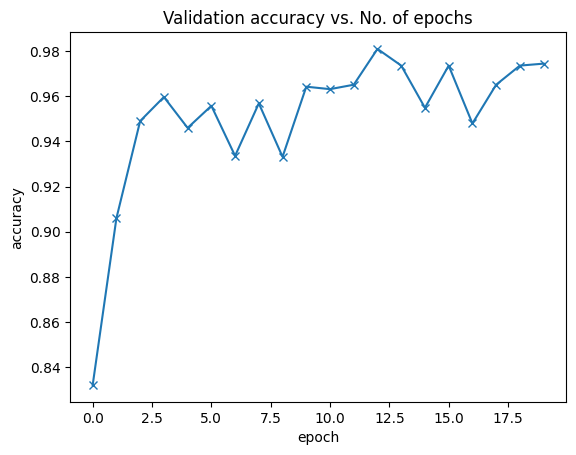

In [21]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy vs. No. of epochs');

plot_accuracies(history)

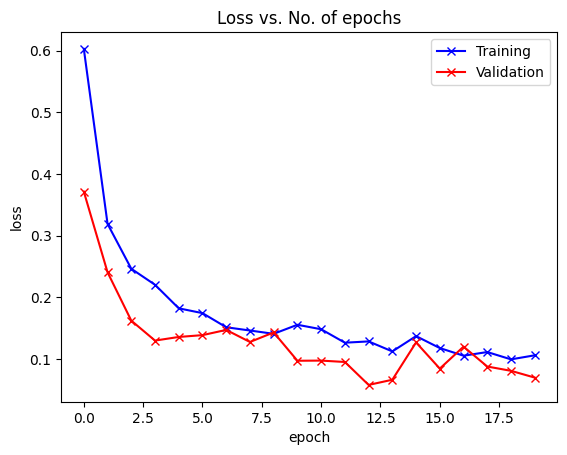

In [22]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

F1 Score: 0.9211
Accuracy: 0.9207
Recall: 0.9207


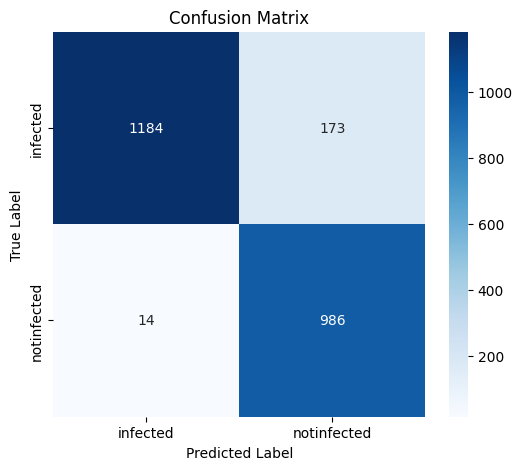

In [23]:


# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate F1 score, accuracy, and recall
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='weighted')

# Print the scores
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['infected', 'notinfected'], yticklabels=['infected', 'notinfected'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



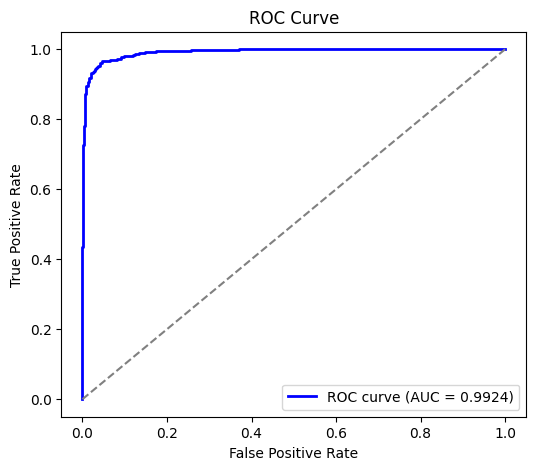

In [24]:
from sklearn.metrics import roc_curve, auc

# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_probs = []  # Store probabilities
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions (raw logits)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# CNN 2 Blocks

In [10]:
class CNN2Block(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(24 * 28 * 28, 2)  # Updated based on the input size

    def forward(self, xb):
        xb = self.block1(xb)  # Pass through block1
        xb = self.block2(xb)  # Pass through block2
        xb = self.flatten(xb)  # Flatten the output
        xb = self.fc(xb)       # Fully connected layer for classification
        return xb
model = CNN2Block()

In [11]:
model = CNN2Block().to(device)  #  using the appropriate device (GPU/CPU)

# Print the model summary
summary(model, input_size=(3, 256, 256))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 256, 256]             336
              ReLU-2         [-1, 12, 256, 256]               0
         MaxPool2d-3           [-1, 12, 85, 85]               0
            Conv2d-4           [-1, 24, 85, 85]           2,616
              ReLU-5           [-1, 24, 85, 85]               0
         MaxPool2d-6           [-1, 24, 28, 28]               0
           Flatten-7                [-1, 18816]               0
            Linear-8                    [-1, 2]          37,634
Total params: 40,586
Trainable params: 40,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 15.59
Params size (MB): 0.15
Estimated Total Size (MB): 16.50
----------------------------------------------------------------


In [12]:
print("Training with 2 CNN block")
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Training with 2 CNN block
Epoch [0], train_loss: 0.4199, val_loss: 0.3088, val_acc: 0.8548
Epoch [1], train_loss: 0.2115, val_loss: 0.1899, val_acc: 0.9277
Epoch [2], train_loss: 0.1648, val_loss: 0.1649, val_acc: 0.9282
Epoch [3], train_loss: 0.1318, val_loss: 0.1231, val_acc: 0.9529
Epoch [4], train_loss: 0.1271, val_loss: 0.1255, val_acc: 0.9592
Epoch [5], train_loss: 0.1121, val_loss: 0.1275, val_acc: 0.9603
Epoch [6], train_loss: 0.0999, val_loss: 0.1080, val_acc: 0.9568
Epoch [7], train_loss: 0.0959, val_loss: 0.1089, val_acc: 0.9701
Epoch [8], train_loss: 0.0890, val_loss: 0.0953, val_acc: 0.9627
Epoch [9], train_loss: 0.0779, val_loss: 0.0806, val_acc: 0.9657
Epoch [10], train_loss: 0.0706, val_loss: 0.0860, val_acc: 0.9681
Epoch [11], train_loss: 0.0696, val_loss: 0.0786, val_acc: 0.9685
Epoch [12], train_loss: 0.0648, val_loss: 0.0671, val_acc: 0.9755
Epoch [13], train_loss: 0.0673, val_loss: 0.1157, val_acc: 0.9557
Epoch [14], train_loss: 0.0633, val_loss: 0.0607, val_acc: 0

In [13]:
#save the model
torch.save(model.state_dict(), 'PCOS_detection_{}_epochs_val_acc_{}.pth'.format(num_epochs, history[-1]['val_acc']))

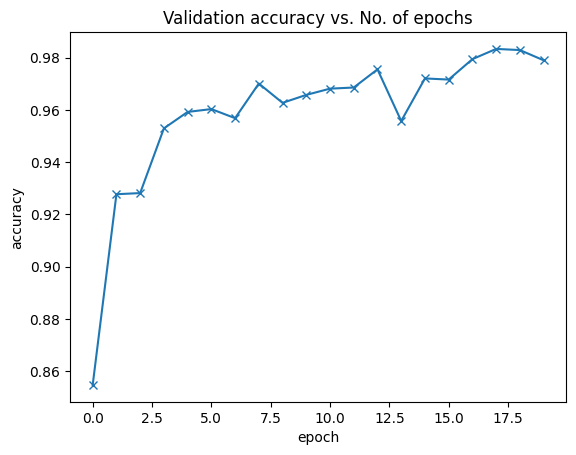

In [14]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy vs. No. of epochs');

plot_accuracies(history)

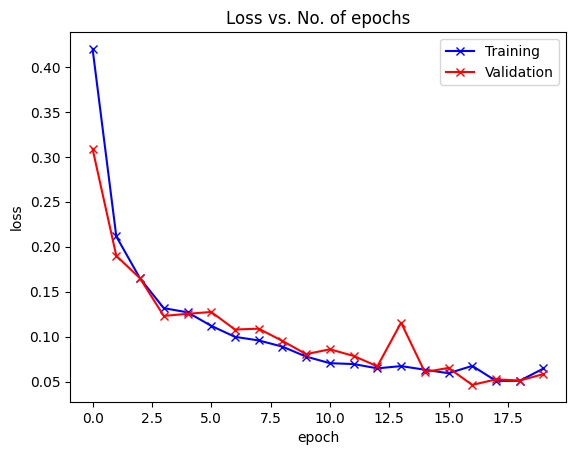

In [15]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

F1 Score: 0.9805
Accuracy: 0.9805
Recall: 0.9805


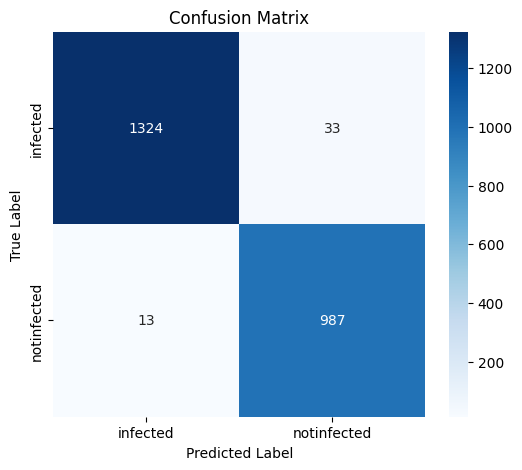

In [17]:


# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate F1 score, accuracy, and recall
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='weighted')

# Print the scores
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['infected', 'notinfected'], yticklabels=['infected', 'notinfected'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



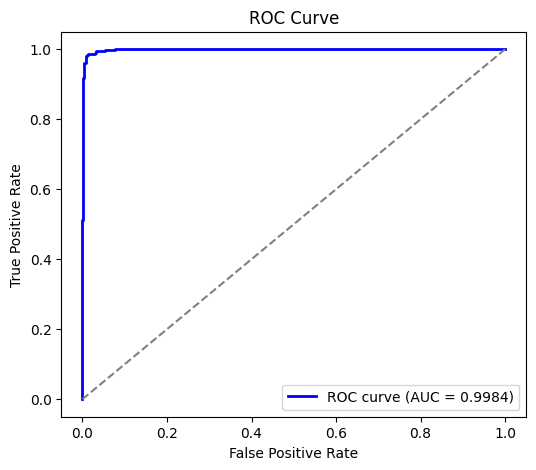

In [18]:
from sklearn.metrics import roc_curve, auc

# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_probs = []  # Store probabilities
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions (raw logits)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [48]:
import torch
from torchvision import transforms
from PIL import Image

# Ensure the model is in evaluation mode
model.eval()

# Path to your image
image_path = '/kaggle/input/data/test/notinfected/img4.jpg'

# Define the transformations (same as used in training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to the correct input size
    transforms.ToTensor(),          # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load and transform the image
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension (1 image in the batch)

# Send the image to the same device as your model (GPU or CPU)
image = image.to(device)

# Make the prediction
with torch.no_grad():  # Disable gradient calculation
    outputs = model(image)  # Forward pass
    _, predicted_class = torch.max(outputs, 1)  # Get the class index (0 or 1)

# Map the class index to a readable label
if predicted_class.item() == 0:
    predicted_label = "infected"
else:
    predicted_label = "notinfected"

# Print the prediction result
print(f"Predicted class: {predicted_label}")


Predicted class: notinfected


# CNN with 3 Blocks

In [10]:
import torch
import torch.nn as nn

class CNN3Block(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(24, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(48 * 9 * 9, 2)  # Adjusted based on input size

    def forward(self, xb):
        xb = self.block1(xb)  # Pass through block1
        xb = self.block2(xb)  # Pass through block2
        xb = self.block3(xb)  # Pass through block3
        xb = self.flatten(xb)  # Flatten the output
        xb = self.fc(xb)       # Fully connected layer for classification
        return xb

# Example initialization
model = CNN3Block()

# Ensure input size compatibility
input_tensor = torch.randn(128, 3, 256, 256)  # Batch size of 128
output = model(input_tensor)
print("Output shape:", output.shape)  # Should be (128, 2)


Output shape: torch.Size([128, 2])


In [11]:
model = CNN3Block().to(device)  #  using the appropriate device (GPU/CPU)

# Print the model summary
summary(model, input_size=(3, 256, 256))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 256, 256]             336
              ReLU-2         [-1, 12, 256, 256]               0
         MaxPool2d-3           [-1, 12, 85, 85]               0
            Conv2d-4           [-1, 24, 85, 85]           2,616
              ReLU-5           [-1, 24, 85, 85]               0
         MaxPool2d-6           [-1, 24, 28, 28]               0
            Conv2d-7           [-1, 48, 28, 28]          10,416
              ReLU-8           [-1, 48, 28, 28]               0
         MaxPool2d-9             [-1, 48, 9, 9]               0
          Flatten-10                 [-1, 3888]               0
           Linear-11                    [-1, 2]           7,778
Total params: 21,146
Trainable params: 21,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/ba

In [12]:
print("Training with 3 CNN block")
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Training with 3 CNN block
Epoch [0], train_loss: 0.3640, val_loss: 0.1904, val_acc: 0.9080
Epoch [1], train_loss: 0.1923, val_loss: 0.1266, val_acc: 0.9538
Epoch [2], train_loss: 0.1576, val_loss: 0.0965, val_acc: 0.9674
Epoch [3], train_loss: 0.1600, val_loss: 0.1416, val_acc: 0.9444
Epoch [4], train_loss: 0.1382, val_loss: 0.0804, val_acc: 0.9798
Epoch [5], train_loss: 0.1222, val_loss: 0.0824, val_acc: 0.9750
Epoch [6], train_loss: 0.1094, val_loss: 0.0655, val_acc: 0.9744
Epoch [7], train_loss: 0.1032, val_loss: 0.0535, val_acc: 0.9813
Epoch [8], train_loss: 0.0958, val_loss: 0.0620, val_acc: 0.9744
Epoch [9], train_loss: 0.1005, val_loss: 0.0546, val_acc: 0.9809
Epoch [10], train_loss: 0.0853, val_loss: 0.0485, val_acc: 0.9907
Epoch [11], train_loss: 0.0868, val_loss: 0.0485, val_acc: 0.9852
Epoch [12], train_loss: 0.0810, val_loss: 0.0434, val_acc: 0.9887
Epoch [13], train_loss: 0.0788, val_loss: 0.0361, val_acc: 0.9926
Epoch [14], train_loss: 0.0678, val_loss: 0.0360, val_acc: 0

In [13]:
#save the model
torch.save(model.state_dict(), 'PCOS_detection_CNN3.pth'.format(num_epochs, history[-1]['val_acc']))AC

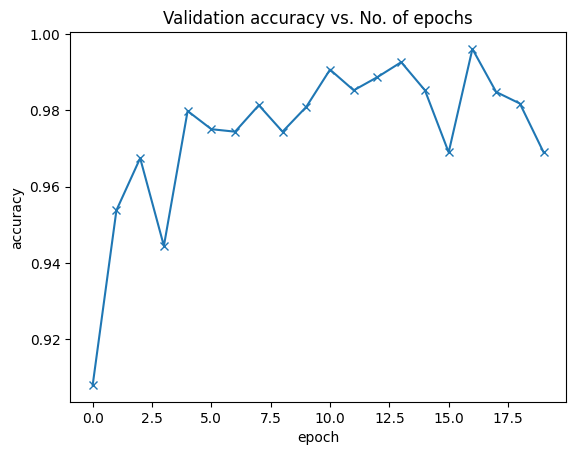

In [14]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy vs. No. of epochs');

plot_accuracies(history)

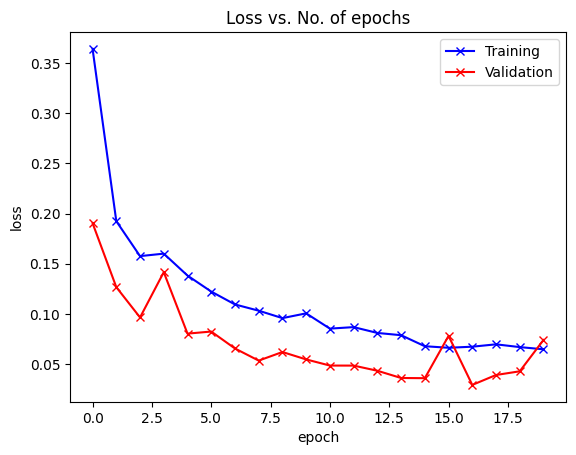

In [15]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

F1 Score: 0.9694
Accuracy: 0.9695
Recall: 0.9695


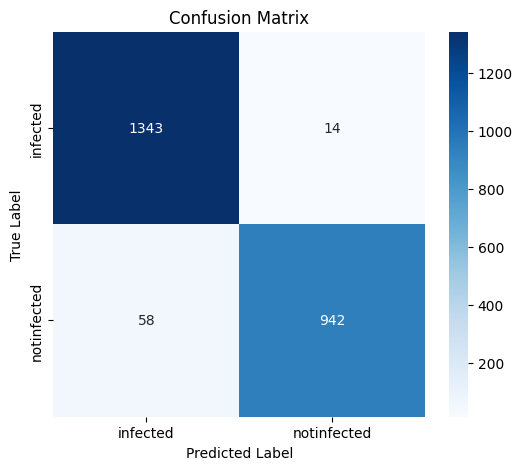

In [16]:


# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate F1 score, accuracy, and recall
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='weighted')

# Print the scores
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['infected', 'notinfected'], yticklabels=['infected', 'notinfected'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



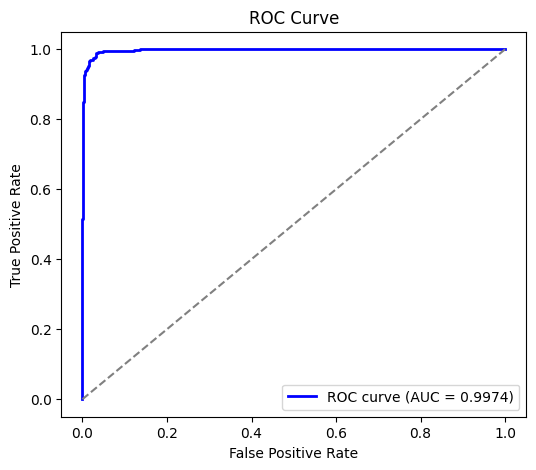

In [17]:
from sklearn.metrics import roc_curve, auc

# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_probs = []  # Store probabilities
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions (raw logits)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


All 3 models has accuracy 1 with 3 block CNN model with faster convergence
Model with 2 block CN have highest accuracy

# VGG16

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torchsummary import summary

# **Check device (GPU/CPU)**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# **Load Pretrained VGG16 Model**
vgg16 = models.vgg16()
vgg16.load_state_dict(torch.load("/kaggle/input/vgg16-weight/vgg16-397923af.pth"))
vgg16 = vgg16.to(device)

Using device: cuda


<ipython-input-10-d8044a76c0c8>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16.load_state_dict(torch.load("/kaggle/input/vgg16-weight/vgg16-397923af.pth"))


In [11]:
# **Freeze All Convolutional Layers**
for param in vgg16.features.parameters():
    param.requires_grad = False

# **Modify Last Layer for Binary Classification**
vgg16.classifier[6] = nn.Linear(4096, 2)  # 2 output classes (PCOS vs non-PCOS)
vgg16 = vgg16.to(device)

# **Print Model Summary**
summary(vgg16, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [12]:
# **Custom Model Class (Aligned with ImageClassificationBase)**
class VGG16PCOS(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = vgg16  # Store VGG16 inside self.model

    def forward(self, xb):
        return self.model(xb)

# **Initialize Model**
model = VGG16PCOS().to(device)

In [13]:
print("Training with VGG-16")
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Training with VGG-16

Epoch [1/20] -------------------------
Epoch [0], train_loss: 0.3267, val_loss: 0.0619, val_acc: 0.9720

Epoch [2/20] -------------------------
Epoch [1], train_loss: 0.0901, val_loss: 0.0441, val_acc: 0.9789

Epoch [3/20] -------------------------
Epoch [2], train_loss: 0.0762, val_loss: 0.0738, val_acc: 0.9642

Epoch [4/20] -------------------------
Epoch [3], train_loss: 0.0714, val_loss: 0.0381, val_acc: 0.9813

Epoch [5/20] -------------------------
Epoch [4], train_loss: 0.0759, val_loss: 0.0800, val_acc: 0.9829

Epoch [6/20] -------------------------
Epoch [5], train_loss: 0.1019, val_loss: 0.0587, val_acc: 0.9759

Epoch [7/20] -------------------------
Epoch [6], train_loss: 0.0884, val_loss: 0.0286, val_acc: 0.9872

Epoch [8/20] -------------------------
Epoch [7], train_loss: 0.0723, val_loss: 0.0289, val_acc: 0.9883

Epoch [9/20] -------------------------
Epoch [8], train_loss: 0.0826, val_loss: 0.0525, val_acc: 0.9833

Epoch [10/20] -------------------

# Evaluation

In [14]:
torch.save(model.state_dict(), "/kaggle/working/vgg16_pcos_trained.pth")
print("Model saved successfully at /kaggle/working/vgg16_pcos_trained.pth")


Model saved successfully at /kaggle/working/vgg16_pcos_trained.pth


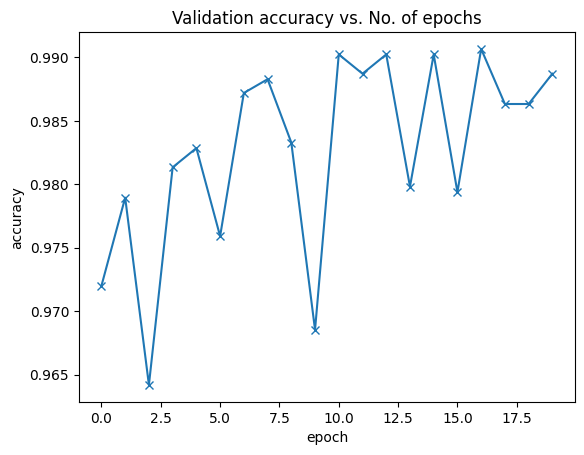

In [15]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy vs. No. of epochs');

plot_accuracies(history)

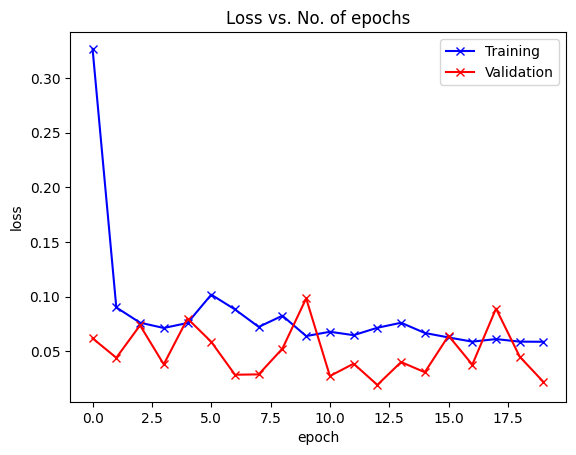

In [16]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

F1 Score: 0.9928
Accuracy: 0.9928
Recall: 0.9928


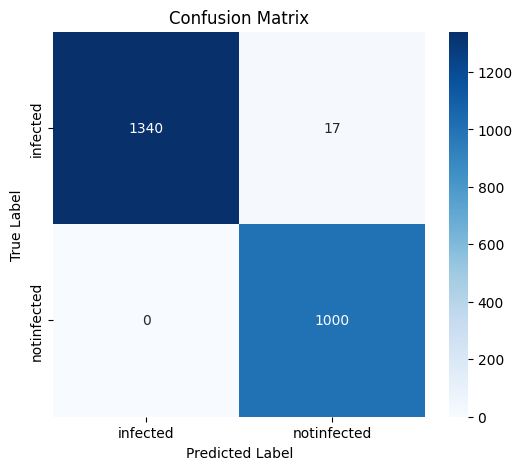

In [17]:


# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate F1 score, accuracy, and recall
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='weighted')

# Print the scores
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['infected', 'notinfected'], yticklabels=['infected', 'notinfected'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



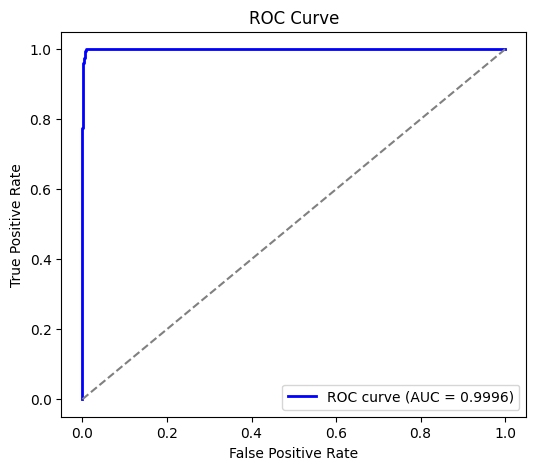

In [19]:
from sklearn.metrics import roc_curve, auc

# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_probs = []  # Store probabilities
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions (raw logits)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
